<a href="https://colab.research.google.com/github/Majd-Wardeh/NN_project_colab/blob/branch1/NN_project_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-05-06 01:53:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  91.9MB/s    in 0.9s    

2020-05-06 01:53:58 (91.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
%matplotlib inline
import io
import os
from os import path
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
def load_data(images_dir, pd_file):
  data = pd_file 
  imgs = []
  labels = []
  points = []
  for index in data.index.values:
    image_file_name = 'screen_640x480_{}.jpg'.format(data['pic number'][index])
    if path.exists(images_dir + '/' + image_file_name):
      r = data['r'][index]
      phai = data['phai'][index]
      theta = data['theta'][index]
      labels.append([r, phai, theta])
      imgs.append(image_file_name)
    else:
      print("{} not found!".format(image_file_name))

  print("found {} images".format(len(imgs)))

  return imgs, labels

In [0]:
def create_train_validation_dataframe(csv_file, random_seed=0):
  data = pd.read_csv(csv_file)

  train_df = data.copy()
  valid_df = data.copy()

  remove_training = []
  remove_validation = []

  np.random.seed(random_seed)
  for index in data.index.values:
    rand = np.random.rand()
    if rand < 0.8:
      remove_validation.append(index)
    else:
      remove_training.append(index)

  train_df = train_df.drop(remove_training)
  valid_df = valid_df.drop(remove_validation)

  print("total images: ", len(list(data.index.values)))
  print("number of training images: {}".format(len(train_df['pic number'])))
  print("number of validation images: {}".format(len(valid_df['pic number'])))

  # train_df.to_csv("/content/drive/My Drive/NN_project/dataset/train_debug.csv")
  return  train_df, valid_df

In [92]:
base_dir = "/content/drive/My Drive/NN_project/dataset"
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_df, valid_df = create_train_validation_dataframe(base_dir + '/coordinates_0_6999_cleaned.csv')

train_img_names, train_labels = load_data(train_dir + '/gate', train_df)
valid_img_names, valid_labels = load_data(validation_dir + '/gate', valid_df)



total images:  6996
number of training images: 5633
number of validation images: 1363
found 5633 images
found 1363 images


In [15]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_weights_dir = '/content/drive/My Drive/NN_project/inception_weights'

pre_trained_model = InceptionV3(input_shape = (240, 320, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


flatten = layers.Flatten()(last_output)
flatten_dropedout = layers.Dropout(0.3)(flatten)

dense1 = layers.Dense(500, activation='relu')(flatten_dropedout)
dense1 = layers.Dropout(0.2)(dense1)                  
 
dense2 = layers.Dense(500, activation='relu')(dense1) 
#dense2 = layers.Dropout(0.2)(dense2)

#dense3 = layers.Dense(1024, activation='tanh')(dense2)

y_estimator = layers.Dense(3, activation='linear')(dense2)

estimation_model = Model( pre_trained_model.input, y_estimator) 
estimation_model.compile(optimizer = Adam(lr=0.001), 
              loss = 'mae')

# estimation_model.summary()

last layer output shape:  (None, 13, 18, 768)


In [19]:
import multiprocessing
import time

class Processor:
  def __init__(self, path, img_names, labels):
    self.labels = labels
    self.img_names = img_names
    self.path = path
    print("hello")

  def __call__(self, index):
    #print(index)
    img_name = self.img_names[index]
    img = Image.open(self.path + '/gate/' + img_name) #.resize((320, 240))
    img = np.array(img, dtype=np.float32)/255.0
    label = self.labels[index]
    # label[1] = label[1]*180.0/np.pi
    # label[2] = label[2]*180.0/np.pi
    return img, label

def get_data_multiprocess(data_dir, img_names, labels, length):
  start = time.time()
  proc=Processor(data_dir, img_names, labels)
  pool=multiprocessing.Pool(processes=8)
  res = pool.map(proc,range(length))
  finish = time.time()
  print("# of images: ", len(res))
  print("time = ", finish-start)
  x_data = np.empty((length, 240, 320, 3), dtype=np.float32)
  y_data = np.empty((length, 3), dtype=np.float32)
  for i, r in enumerate(res):
    x, y = r
    x_data[i, ] = x 
    y_data[i, ] = y 
  return x_data, y_data


x_train, y_train = None, None
x_train, y_train = get_data_multiprocess(train_dir, train_img_names, train_labels, int(len(train_labels)))

x_valid, y_valid = None, None
x_valid, y_valid = get_data_multiprocess(validation_dir, valid_img_names, valid_labels, int(len(valid_img_names)))

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

hello
# of images:  5633
time =  448.4343798160553
hello
# of images:  1363
time =  127.32338571548462
(5633, 240, 320, 3) (5633, 3)
(1363, 240, 320, 3) (1363, 3)


In [0]:
history = estimation_model.fit(x_train, y_train,
                    batch_size = 100,
                    validation_data = (x_valid, y_valid),                                 
                    steps_per_epoch = 5,
                    epochs=200)

In [0]:
load1_or_save0 = 
name = "/content/drive/My Drive/NN_project/inception_weights/weights_MAE_2layers_500each_relu_{}.h5".format(time.time())
if load1_or_save0 == 0:
  estimation_model.save_weights(name)
else:
  estimation_model.load_weights(name)

In [0]:
for layer in estimation_model.layers:
  layer.trainable = True

In [0]:
index = np.random.randint(len(train_labels))
y_pred = estimation_model.predict(np.expand_dims(x_train[index], axis=0))[0]
y_true = y_train[index]
print(y_true)
print(y_pred)
print(tf.keras.losses.mean_absolute_error(y_true, y_pred), tf.keras.losses.mean_squared_error(y_true, y_pred))

[  9.158958 108.18209   24.893665]
[ 5.62732  86.88761  18.594076]
tf.Tensor(10.375236, shape=(), dtype=float32) tf.Tensor(168.53738, shape=(), dtype=float32)


In [0]:
import numpy.linalg as la

y_pred = estimation_model.predict(x_train)
y_true = y_train

l2_norm = la.norm(y_true - y_pred, axis = 1)
print("norm of the error = ", l2_norm.shape)
print("mse = ", np.mean(l2_norm))
print("meidan = ", np.median(l2_norm))


norm of the error =  (5633,)
mse =  52.98559
meidan =  55.088097


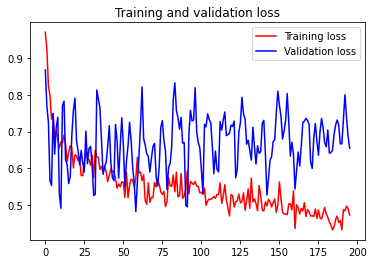

In [10]:
import matplotlib.pyplot as plt
import time
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
start = 4
end = len(loss)
loss = loss[start:end]
val_loss = val_loss[start:end]
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
#plt.savefig(base_dir + "/MAE_relu_2layers_500each_{}.png".format(time.time()))


plt.show()

In [0]:
# !cp -r "drive/My Drive/NN_project/dataset/validation/gate/." "drive/My Drive/NN_project/dataset/images/"

In [0]:
# !ls "drive/My Drive/NN_project/dataset/images/"


In [0]:
# !rm -d -r "drive/My Drive/NN_project/dataset/images"

In [0]:
# !mkdir "drive/My Drive/NN_project/dataset/images"